# Faces Gray2RGB

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
%matplotlib inline

## Prepare the dataset

In [4]:
# Un comment when downloading the dataset
# !wget http://vis-www.cs.umass.edu/lfw/lfw.tgz
# !tar -xvf lfw.tgz

In [5]:
data_folder = 'lfw'
lfw_names = os.listdir(data_folder)
images_list = []
for person in lfw_names:
  for file_ in os.listdir(os.path.join(data_folder, person)):
    if file_.endswith('jpg'):
      images_list.append(os.path.join(data_folder, person, file_))
print('Total: {} images'.format(len(images_list)))

Total: 13233 images


In [6]:
images_list[:10]

['lfw/Vaclav_Klaus/Vaclav_Klaus_0002.jpg',
 'lfw/Vaclav_Klaus/Vaclav_Klaus_0001.jpg',
 'lfw/Katie_Smith/Katie_Smith_0001.jpg',
 'lfw/Gianna_Angelopoulos-Daskalaki/Gianna_Angelopoulos-Daskalaki_0003.jpg',
 'lfw/Gianna_Angelopoulos-Daskalaki/Gianna_Angelopoulos-Daskalaki_0002.jpg',
 'lfw/Gianna_Angelopoulos-Daskalaki/Gianna_Angelopoulos-Daskalaki_0001.jpg',
 'lfw/Gro_Harlem_Brundtland/Gro_Harlem_Brundtland_0002.jpg',
 'lfw/Gro_Harlem_Brundtland/Gro_Harlem_Brundtland_0001.jpg',
 'lfw/Zarai_Toledo/Zarai_Toledo_0002.jpg',
 'lfw/Zarai_Toledo/Zarai_Toledo_0001.jpg']

In [7]:
train_images, test_images = train_test_split(images_list, test_size=0.2)
print('Train images: {}'.format(len(train_images)))
print('Test images: {}'.format(len(test_images)))

Train images: 10586
Test images: 2647


In [76]:
def map_image(image_path):
  rgb = tf.io.read_file(image_path)
  rgb = tf.image.decode_jpeg(rgb, channels=3)
  rgb = tf.image.resize(rgb, (224, 224))
  gray = tf.image.rgb_to_grayscale(rgb)
  rgb = tf.cast(rgb, dtype=tf.float32)
  gray = tf.cast(gray, dtype=tf.float32)
  rgb = rgb / 255.0
  gray = gray / 255.0
  return gray, rgb

In [77]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1024

train_dataset = tf.data.Dataset.from_tensor_slices(train_images).map(map_image)
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE).repeat()

test_dataset = tf.data.Dataset.from_tensor_slices(test_images).map(map_image)
test_dataset = test_dataset.batch(BATCH_SIZE).repeat()

## Define the model

In [106]:
def encoder(inputs, layer_filters, kernel_size):
  x = inputs
  for filters in layer_filters:
    x = tf.keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=2, activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)

  shape = tf.keras.backend.int_shape(x)
  # x = tf.keras.layers.Flatten()(x)
  # x = tf.keras.layers.GlobalAvgPool2D()(x)
  # x = tf.keras.layers.Dense(latent_dim)(x)
  x = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(x)
  return x, shape

In [107]:
def decoder(inputs, shape, latent_dim, channels):
  #latent_inputs = tf.keras.layers.Input(shape=(latent_dim))
  # x = tf.keras.layers.Dense(shape[1] * shape[2] * shape[3])(inputs)
  # x = tf.keras.layers.Reshape((shape[1], shape[2], shape[3]))(x)

  x = inputs
  for filters in layer_filters[::-1]:
    x = tf.keras.layers.Conv2DTranspose(filters=filters, kernel_size=kernel_size, strides=2, activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)

  x = tf.keras.layers.Conv2DTranspose(filters=channels, kernel_size=kernel_size, activation='sigmoid', padding='same')(x)
  return x

In [108]:
def convolutional_autoencoder(input_shape, layer_filters, kernel_size, latent_dim, channels):
  inputs = tf.keras.layers.Input(shape=input_shape)
  encoder_output, shape = encoder(inputs, layer_filters, kernel_size)
  decoder_output = decoder(encoder_output, shape, latent_dim, channels)

  model = tf.keras.Model(inputs=inputs, outputs=decoder_output)
  return model

In [132]:
input_shape = (224, 224, 1)
kernel_size = 3
latent_dim = 256
channels = 3
layer_filters = [32, 64, 128]

convolutional_model = convolutional_autoencoder(input_shape, layer_filters, kernel_size, latent_dim, channels)
convolutional_model.summary()

Model: "model_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        [(None, 224, 224, 1)]     0         
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 112, 112, 32)      320       
_________________________________________________________________
batch_normalization_14 (Batc (None, 112, 112, 32)      128       
_________________________________________________________________
conv2d_53 (Conv2D)           (None, 56, 56, 64)        18496     
_________________________________________________________________
batch_normalization_15 (Batc (None, 56, 56, 64)        256       
_________________________________________________________________
conv2d_54 (Conv2D)           (None, 28, 28, 128)       73856     
_________________________________________________________________
batch_normalization_16 (Batc (None, 28, 28, 128)       512

In [133]:
convolutional_model.compile(optimizer=tf.keras.optimizers.Adam(), 
                            loss='mean_squared_error')

## Train the model

In [134]:
train_steps = len(train_images) // BATCH_SIZE
valid_steps = len(test_images) // BATCH_SIZE

history = convolutional_model.fit(train_dataset, steps_per_epoch=train_steps, 
                                  validation_data=test_dataset, validation_steps=valid_steps, 
                                  epochs=10)

Epoch 1/10
330/330 [==============================] - 66s 192ms/step - loss: 0.0194 - val_loss: 0.0504
Epoch 2/10
330/330 [==============================] - 65s 196ms/step - loss: 0.0083 - val_loss: 0.0080
Epoch 3/10
330/330 [==============================] - 65s 197ms/step - loss: 0.0069 - val_loss: 0.0066
Epoch 4/10
330/330 [==============================] - 66s 200ms/step - loss: 0.0066 - val_loss: 0.0059
Epoch 5/10
330/330 [==============================] - 67s 202ms/step - loss: 0.0064 - val_loss: 0.0064
Epoch 6/10
330/330 [==============================] - 67s 202ms/step - loss: 0.0061 - val_loss: 0.0084
Epoch 7/10
330/330 [==============================] - 67s 203ms/step - loss: 0.0062 - val_loss: 0.0056
Epoch 8/10
330/330 [==============================] - 66s 201ms/step - loss: 0.0061 - val_loss: 0.0071
Epoch 9/10
330/330 [==============================] - 67s 202ms/step - loss: 0.0060 - val_loss: 0.0075
Epoch 10/10
330/330 [==============================] - 67s 202ms/step - l

## Display sample

In [135]:
from google.colab import files

In [136]:
from_dataset = False

if from_dataset:
  test_data = next(iter(test_dataset))
  idx = 3
  gray_img = test_data[0][idx]
  color_img = test_data[1][idx]
else:
  uploaded = files.upload()
  for fn in uploaded.keys():
    gray_img, color_img = map_image(fn)

Saving ew.jpeg to ew.jpeg


In [137]:
predicted = convolutional_model.predict(gray_img[tf.newaxis, ...])

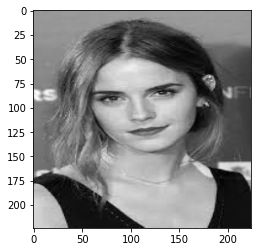

In [138]:
plt.imshow(np.squeeze(gray_img), cmap='gray')

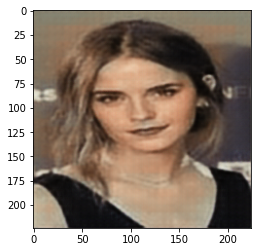

In [139]:
plt.imshow(np.squeeze(predicted))

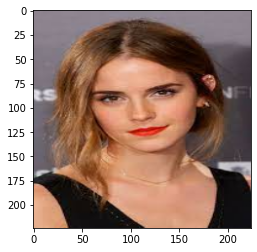

In [140]:
plt.imshow(np.squeeze(color_img))